In [40]:
from python_speech_features import mfcc, logfbank
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import scipy
import sklearn
import librosa
import librosa.display
import IPython.display as ipd
import json
from scipy.signal import find_peaks
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import pandas as pd
from random import shuffle
from sklearn.ensemble import RandomForestClassifier

In [2]:
def get_xy(audio_path, level_path, tempo):
    # read audio and calculate tempo
    y, sr = librosa.load(audio_path)

    # get spectrogram
    S = librosa.feature.melspectrogram(y, n_mels=16, hop_length=512)
    log_S = librosa.power_to_db(S)
    X = log_S.T

    # read level
    with open(level_path, 'r') as f:
        data = json.load(f)
        t = np.array(sorted(list(set([el['_time'] for el in data['_notes']]))))
        
        mask = librosa.time_to_frames(t / tempo * 60, hop_length=512)
        res = np.zeros(log_S.shape[1])
        res[mask] = 1
        
    return X, res

In [3]:
df = pd.read_csv('data_info2.csv')
df.head()

,song_id,song_name,song_author,song_file,bpm,Easy,Normal,Hard,Expert,ExpertPlus
0,aaj,Aaj,Bloodywood,song.ogg,180.000000,Easy.dat,NaN,NaN,NaN,NaN
1,africatotometalcover,Africa - Toto (Metal Cover),"Leo Moracchioli, Rabea, Hannah",song.ogg,105.000000,NaN,NaN,NaN,NaN,ExpertPlus.dat
2,afterlife,Afterlife,Avenged Sevenfold,song.ogg,220.000000,Easy.dat,NaN,NaN,NaN,NaN
3,alerion,Alerion,Asking Alexandria,song.ogg,130.000000,NaN,NormalStandard.dat,HardStandard.dat,NaN,ExpertPlusStandard.dat
4,alittlepieceofheaven,A Little Piece of Heaven,Avenged Sevenfold,song.ogg,144.985992,NaN,NaN,NaN,NaN,NaN


In [4]:
song_ids = list(df[~df['Easy'].isnull()]['song_id'])
shuffle(song_ids)

In [5]:
song_ids_train = song_ids[:400]
song_ids_test = song_ids[400:]

In [6]:
len(song_ids_train), len(song_ids_test)

(400, 172)

In [7]:
df_train = df[df['song_id'].isin(song_ids_train)]
df_test = df[df['song_id'].isin(song_ids_test)]

In [8]:
train_X, test_X = [], []
train_y, test_y = [], []

In [12]:
for i, el in df_train.iterrows():
    try:
        path = 'data/' + el['song_id'] + '/'
        el_X, el_y = get_xy(path + el['song_file'], path + el['Easy'], el['bpm'])
        train_X.append(el_X)
        train_y.append(el_y)
    except:
        print('Error: ', i)
        
    if i % 10 == 0:
        print(i)

30
40
50
70
90
110
120
150
160
Error:  190
190
200
210
230
290
320
350
Error:  384
400
410
450
470
480
500
510
540
550
570
590
600
610
640
660
670
700
720
740
760
770
790


In [26]:
X_train = np.vstack(train_X)

In [27]:
X_train.shape

(3772800, 16)

In [28]:
y_train = np.hstack(train_y)

In [29]:
y_train.shape

(3772800,)

In [30]:
np.save('X_train.npy', X_train)

In [31]:
np.save('y_train.npy', y_train)

In [32]:
for i, el in df_test.iterrows():
    try:
        path = 'data/' + el['song_id'] + '/'
        el_X, el_y = get_xy(path + el['song_file'], path + el['Easy'], el['bpm'])
        test_X.append(el_X)
        test_y.append(el_y)
    except:
        print('Error: ', i)
        
    if i % 10 == 0:
        print(i)

0
Error:  198
240
300
340
380
420
430
Error:  433
520
560
620
690
710
780
800
820


In [33]:
X_test = np.vstack(test_X)

In [34]:
X_test.shape

(1638318, 16)

In [35]:
y_test = np.hstack(test_y)

In [38]:
y_test.shape

(1638318,)

In [60]:
len(test_X)

170

In [59]:
y_test, y_val = test_y[:85], test_y[85:]

In [61]:
X_test, X_val = test_X[:85], test_X[85:]

In [62]:
X_test = np.vstack(X_test)

In [63]:
X_val = np.vstack(X_val)

In [64]:
X_test.shape

(838729, 16)

In [65]:
X_val.shape

(799589, 16)

In [66]:
y_test = np.hstack(y_test)
y_val = np.hstack(y_val)

In [67]:
y_test.shape

(838729,)

In [68]:
y_val.shape

(799589,)

In [69]:
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)

In [70]:
np.save('X_val.npy', X_val)
np.save('y_val.npy', y_val)

In [46]:
clf = RandomForestClassifier(random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 13.3min finished


RandomForestClassifier(n_jobs=-1, random_state=42, verbose=1)

In [47]:
y_train_pred = clf.predict(X_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   13.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   39.1s finished


In [48]:
print(classification_report(y_train_pred, y_train))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   3479241
         1.0       1.00      1.00      1.00    293559

    accuracy                           1.00   3772800
   macro avg       1.00      1.00      1.00   3772800
weighted avg       1.00      1.00      1.00   3772800



In [49]:
confusion_matrix(y_train_pred, y_train)

array([[3479114,     127],
       [      0,  293559]], dtype=int64)

In [71]:
y_val_pred = clf.predict(X_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.6s finished


In [72]:
print(classification_report(y_val_pred, y_val))

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799510
         1.0       0.00      0.10      0.00        79

    accuracy                           0.92    799589
   macro avg       0.50      0.51      0.48    799589
weighted avg       1.00      0.92      0.96    799589



In [73]:
confusion_matrix(y_val_pred, y_val)

array([[738685,  60825],
       [    71,      8]], dtype=int64)

In [53]:
clf.feature_importances_

array([0.0716696 , 0.06364699, 0.06064752, 0.06046184, 0.05990688,
       0.05989372, 0.05919757, 0.06014062, 0.06027722, 0.06030549,
       0.06097243, 0.06170356, 0.06652786, 0.06648474, 0.06352924,
       0.06463474])

In [74]:
clf = RandomForestClassifier(class_weight='balanced', random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.0min finished


RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42,
                       verbose=1)

In [75]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:   11.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   34.1s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   3479264
         1.0       1.00      1.00      1.00    293536

    accuracy                           1.00   3772800
   macro avg       1.00      1.00      1.00   3772800
weighted avg       1.00      1.00      1.00   3772800



array([[3479114,     150],
       [      0,  293536]], dtype=int64)

In [76]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    7.4s finished


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799510
         1.0       0.00      0.11      0.00        79

    accuracy                           0.92    799589
   macro avg       0.50      0.52      0.48    799589
weighted avg       1.00      0.92      0.96    799589



array([[738686,  60824],
       [    70,      9]], dtype=int64)

In [77]:
clf = RandomForestClassifier(max_depth=5, random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  3.8min finished


RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42, verbose=1)

In [78]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.9s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    6.6s finished
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   3772800
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92   3772800
   macro avg       0.50      0.46      0.48   3772800
weighted avg       1.00      0.92      0.96   3772800



array([[3479114,  293686],
       [      0,       0]], dtype=int64)

In [79]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.3s finished
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799589
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92    799589
   macro avg       0.50      0.46      0.48    799589
weighted avg       1.00      0.92      0.96    799589



array([[738756,  60833],
       [     0,      0]], dtype=int64)

In [80]:
clf = RandomForestClassifier(max_depth=10, random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.3min finished


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42, verbose=1)

In [81]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    2.6s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    8.3s finished


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   3772795
         1.0       0.00      1.00      0.00         5

    accuracy                           0.92   3772800
   macro avg       0.50      0.96      0.48   3772800
weighted avg       1.00      0.92      0.96   3772800



array([[3479114,  293681],
       [      0,       5]], dtype=int64)

In [82]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.8s finished
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799589
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92    799589
   macro avg       0.50      0.46      0.48    799589
weighted avg       1.00      0.92      0.96    799589



array([[738756,  60833],
       [     0,      0]], dtype=int64)

In [83]:
clf = RandomForestClassifier(max_depth=15, random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  8.4min finished


RandomForestClassifier(max_depth=15, n_jobs=-1, random_state=42, verbose=1)

In [84]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    3.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   11.4s finished


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   3772426
         1.0       0.00      1.00      0.00       374

    accuracy                           0.92   3772800
   macro avg       0.50      0.96      0.48   3772800
weighted avg       1.00      0.92      0.96   3772800



array([[3479114,  293312],
       [      0,     374]], dtype=int64)

In [85]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.7s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    2.4s finished
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\mariz\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labe

              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799589
         1.0       0.00      0.00      0.00         0

    accuracy                           0.92    799589
   macro avg       0.50      0.46      0.48    799589
weighted avg       1.00      0.92      0.96    799589



array([[738756,  60833],
       [     0,      0]], dtype=int64)

In [86]:
clf = RandomForestClassifier(max_depth=20, random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 12.2min finished


RandomForestClassifier(max_depth=20, n_jobs=-1, random_state=42, verbose=1)

In [88]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    8.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:   25.3s finished


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96   3769025
         1.0       0.01      1.00      0.03      3775

    accuracy                           0.92   3772800
   macro avg       0.51      0.96      0.49   3772800
weighted avg       1.00      0.92      0.96   3772800



array([[3479111,  289914],
       [      3,    3772]], dtype=int64)

In [87]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    1.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    5.0s finished


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96    799573
         1.0       0.00      0.06      0.00        16

    accuracy                           0.92    799589
   macro avg       0.50      0.49      0.48    799589
weighted avg       1.00      0.92      0.96    799589



array([[738741,  60832],
       [    15,      1]], dtype=int64)

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42, verbose=1, n_jobs=-1)
clf.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed: 23.3min
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed: 51.1min


In [ ]:
y_train_pred = clf.predict(X_train)
print(classification_report(y_train_pred, y_train))
confusion_matrix(y_train_pred, y_train)

In [ ]:
y_val_pred = clf.predict(X_val)
print(classification_report(y_val_pred, y_val))
confusion_matrix(y_val_pred, y_val)

In [11]:
el_X, el_y = get_xy('data/aaj/song.ogg', 'data/aaj/Easy.dat', 180)

In [13]:
# read audio and calculate tempo
y, sr = librosa.load('data/aaj/song.ogg')
tempo = librosa.beat.tempo(y)

# get spectrogram
S = librosa.feature.melspectrogram(y, n_mels=16, hop_length=512)
log_S = librosa.power_to_db(S)
X = log_S.T

In [14]:
# read level
with open('data/aaj/Easy.dat', 'r') as f:
    data = json.load(f)
    t = np.array(sorted(list(set([el['_time'] for el in data['_notes']]))))

In [20]:
mask = librosa.time_to_frames(t / 180 * 60, hop_length=512)

In [21]:
mask

array([  502,   509,   513, ..., 12561, 12568, 12575])

In [18]:
log_S.shape

(16, 13021)

In [19]:
tempo

array([117.45383523])

In [291]:
get_xy('data/amalfi/song.ogg', 'data/amalfi/Easy.dat')

(array([[-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511],
        [-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511],
        [-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511],
        ...,
        [-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511],
        [-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511],
        [-50.43511, -50.43511, -50.43511, ..., -50.43511, -50.43511,
         -50.43511]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.]))

In [238]:
audio_path = 'data/amalfi/song.ogg'
y, sr = librosa.load(audio_path)

with open('data/amalfi/Easy.dat', 'r') as f:
    data = json.load(f)
    t = np.array(sorted(list(set([el['_time'] for el in data['_notes']]))))
    
tempo = librosa.beat.tempo(y)

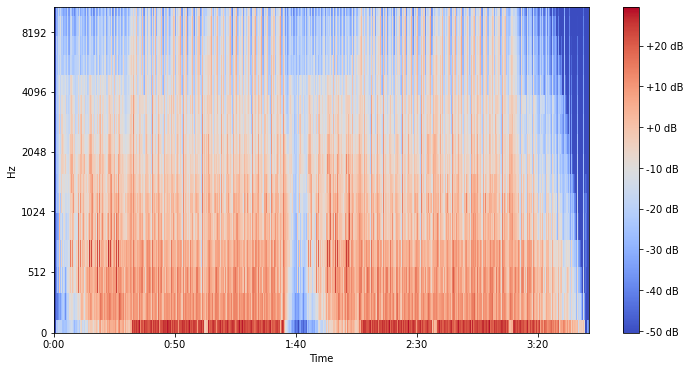

In [239]:
fig, ax = plt.subplots(figsize=(12, 6))
S = librosa.feature.melspectrogram(y, n_mels=16, hop_length=512)
log_S = librosa.power_to_db(S)
img = librosa.display.specshow(log_S, x_axis='time', y_axis='mel', sr=sr, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')

In [244]:
log_S.shape[1]

9531

In [241]:
mask = librosa.time_to_frames(t / tempo * 60, hop_length=512)

In [245]:
res = np.zeros(log_S.shape[1])
res[mask] = 1

In [246]:
np.unique(res, return_counts=True)

(array([0., 1.]), array([8746,  785], dtype=int64))

In [247]:
np.corrcoef(log_S[15], res)

array([[1.        , 0.05864586],
       [0.05864586, 1.        ]])

In [210]:
log_S

array([[-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787],
       [-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787],
       [-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787],
       ...,
       [-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787],
       [-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787],
       [-53.428787, -53.428787, -53.428787, ..., -53.428787, -53.428787,
        -53.428787]], dtype=float32)

In [249]:
X = log_S.T

In [250]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X, res)

RandomForestClassifier(random_state=42)

In [251]:
clf.score(X, res)

0.9998950792151925

In [252]:
y_pred = clf.predict(X)

In [253]:
len(y_pred), len(res)

(9531, 9531)

In [254]:
print(classification_report(res, y_pred))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8746
         1.0       1.00      1.00      1.00       785

    accuracy                           1.00      9531
   macro avg       1.00      1.00      1.00      9531
weighted avg       1.00      1.00      1.00      9531



In [255]:
confusion_matrix(res, y_pred)

array([[8746,    0],
       [   1,  784]], dtype=int64)

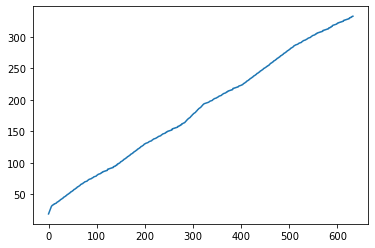

In [94]:
plt.plot(t)

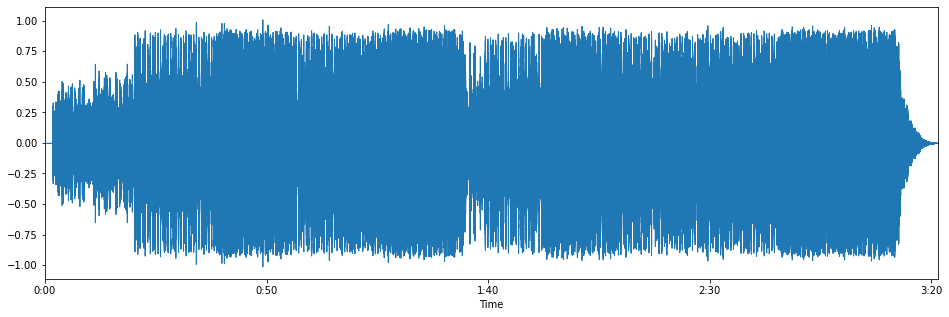

In [81]:
plt.figure(figsize=(16, 5))
librosa.display.waveplot(y)

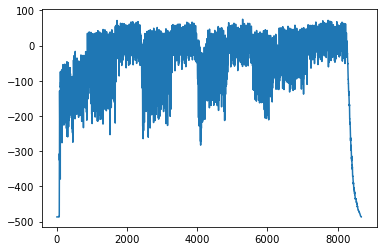

In [9]:
plt.plot(mfcc[0])

In [14]:
t = t / (tempo * dur / 60) * mfcc.shape[1] # normalize to 1 and turn into mfcc dimention
t = np.isin(np.arange(0, mfcc.shape[1]), t.astype(int)).astype(int) # put 0 if index not in t else 1

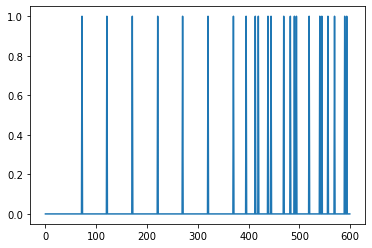

In [24]:
plt.plot(t[400:1000])

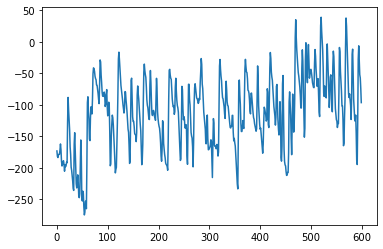

In [27]:
plt.plot(mfcc[0, 400:1000])

In [17]:
np.corrcoef(mfcc[0], t)

array([[1.        , 0.15514487],
       [0.15514487, 1.        ]])

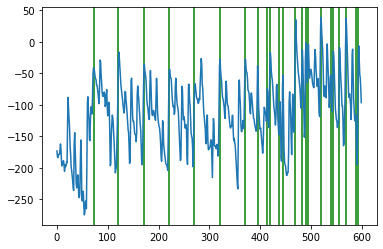

In [45]:
for el in np.where(t == 1)[0]:
    if 400 < el < 1000:
        plt.axvline(x=el-400, color='g')
        
plt.plot(mfcc[0, 400:1000])